# openEO remote processing

In this second exercise we use the [EODC](https://eodc.eu/) openEO service as our data source, and, more importantly, as our processing center. 

## Setting-up a Python session

We again begin by loading openEO and some additional packages. 


In [1]:
import numpy as np
import xarray as xr
from datetime import datetime

from openeo_flood_mapper_local.view_flood_map import view_flood_map

import openeo
from openeo.processes import ProcessBuilder, array_element, add, multiply, sin, cos, mask, exp, median

## Connect to the EODC openEO Back-end

Establish a connection to the EODC back-end with `openeo.connect()`. This results in a connection object which is a critical aspect of collection discovery on the back-end by openEO. 


In [2]:
backend = "https://openeo.eodc.eu" 
connection = openeo.connect(backend)
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.eodc.eu/openeo/1.1.0/' with OidcBearerAuth>

## Load Collections from the EODC

We can first have a look at the metadata available at the EODC for the required collections (SENTINEL1_SIG0_20M, SENTINEL1_HPAR, and SENTINEL1_MPLIA), like so:


In [3]:
connection.collection_metadata("SENTINEL1_SIG0_20M")

We can then load the collections. This is done by using the method `load_collection()` and by using the collection ids as defined above. During collection loading we also do some initial filtering for convenience. We use the following criteria for filtering.


In [4]:
spatial_extent = {"west": 22, "south": 39.483774, "east": 22.225465, "north": 39.6}
sensing_date = ["2018-02-28T04:00:00Z", "2018-02-28T05:00:00Z"]

In [5]:
sig0_dc = connection.load_collection(
    "SENTINEL1_SIG0_20M",
    spatial_extent = spatial_extent,
    temporal_extent = sensing_date,
    bands=["VV"]
). \
    mean_time()

In [6]:
connection.collection_metadata("SENTINEL1_HPAR")

In [7]:
hparam_dc = connection.load_collection(
    "SENTINEL1_HPAR",
    spatial_extent = spatial_extent,
    temporal_extent = "2019"
). \
    mean_time()

In [8]:
connection.collection_metadata("SENTINEL1_MPLIA")

In [9]:
plia_dc = connection.load_collection(
    "SENTINEL1_MPLIA",
    spatial_extent = spatial_extent,
    temporal_extent = ["2020-01-01", "2020-12-31"],
    bands=["MPLIA"]
). \
    mean_time()

## openEO Analysis at the EODC

The remainder of the worklfow is similar to the local processing with some minor differences associated to naming of the objects.


In [10]:
def water_backscatter(plia_dc):
    return (plia_dc.band('MPLIA') * -0.394181 + -4.142015). \
        add_dimension('bands', 'wbsc', 'bands')

Here we apply again the `water_backscatter()` function to the incidence angle datacube, as follows:


In [11]:
water_bsc_dc = water_backscatter(plia_dc)
water_bsc_dc

To initiate the processing we create a batch job with the `create_job()` method. This performs the data processing based on the JSON representation of the processing graph. Only by submitting this job to the EODC backend, we can actually perform the processing, like so:


In [12]:
#| eval: false
water_bsc_res = water_bsc_dc.save_result(format = "NetCDF")
water_bsc_job = water_bsc_res.create_job(title = "water_bsc_greece_flood_2018_as_NetCDF_py")
water_bsc_job.start_job()

We can then download the results and view the retrieved data.


In [13]:
#| eval: false
water_bsc_job.download_result("data/watter_backscatter/example.nc")
water_bsc_dc = xr.open_dataset("data/watter_backscatter/example.nc")
water_bsc_dc

The following code is a duplicate of the local flood mapping processing pipeline, where we define the harmonic model.


In [14]:
def harmonic_expected_backscatter(data, dtime_str):
    w = np.pi * 2 / 365
    dt = datetime.strptime(dtime_str, "%Y-%m-%d")
    t = dt.timetuple().tm_yday
    wt = w * t

    M0 = data.band('M0')
    S1 = data.band('S1')
    S2 = data.band('S2')
    S3 = data.band('S3')
    C1 = data.band('C1')
    C2 = data.band('C2')
    C3 = data.band('C3')
    hm_c1 = (M0 + S1 * np.sin(wt)) + (C1 * np.cos(wt))
    hm_c2 = ((hm_c1 + S2 * np.sin(2 * wt)) + C2 * np.cos(2 * wt))
    hm_c3 = ((hm_c2 + S3 * np.sin(3 * wt)) + C3 * np.cos(3 * wt))
    return hm_c3.add_dimension('bands', 'hbsc', 'bands')

Perform this function on the datacube for the time slice of the flooding event.


In [15]:
land_bsc_dc = harmonic_expected_backscatter(hparam_dc, '2018-02-01')

In turn, we define the Bayesian classification model, as follows:


In [16]:
def bayesian_flood_decision(x: ProcessBuilder) -> ProcessBuilder:
    nf_std = 2.754041
    sig0 = x.array_element(index=0)
    std = x.array_element(index=1)
    wbsc = x.array_element(index=2)
    hbsc = x.array_element(index=3)

    f_prob = (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * \
        (((sig0 - wbsc) / nf_std) ** 2))
    nf_prob = (1.0 / (nf_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * \
        (((sig0 - hbsc) / nf_std) ** 2))

    evidence = (nf_prob * 0.5) + (f_prob * 0.5)
    f_post_prob = (f_prob * 0.5) / evidence 
    nf_post_prob = (nf_prob * 0.5) / evidence 

    # flood if flood class has higher probability
    return f_post_prob.gt(nf_post_prob)

And then execute this on a combined data cube, as follows:


In [17]:
std_dc = hparam_dc.band('STD').add_dimension('bands', 'std', 'bands')
sig0_dc = sig0_dc.reduce_bands('mean').add_dimension('bands', 'sig0', 'bands')

decision_in_dc = sig0_dc. \
    merge_cubes(std_dc). \
    merge_cubes(water_bsc_dc). \
    merge_cubes(land_bsc_dc) . \
    merge_cubes(plia_dc)

flood_dc = decision_in_dc.reduce_bands(bayesian_flood_decision). \
    add_dimension('bands', 'dec', 'bands')

flood_dc = flood_dc.merge_cubes(decision_in_dc)

Finally, we can again proceed and send this processing pipeline of to the EODC.


In [18]:
#| eval: false
flood_res = flood_dc.save_result(format = "NetCDF")
flood_job = flood_res.create_job(title = "flood_greece_flood_2018_as_NetCDF_py")
flood_job.start_job()

And retrieve the data, like so:


In [19]:
#| eval: false
flood_job.download("data/thessaly_floodmap.nc")

Now let's have a look at the processing job performed at EODC.


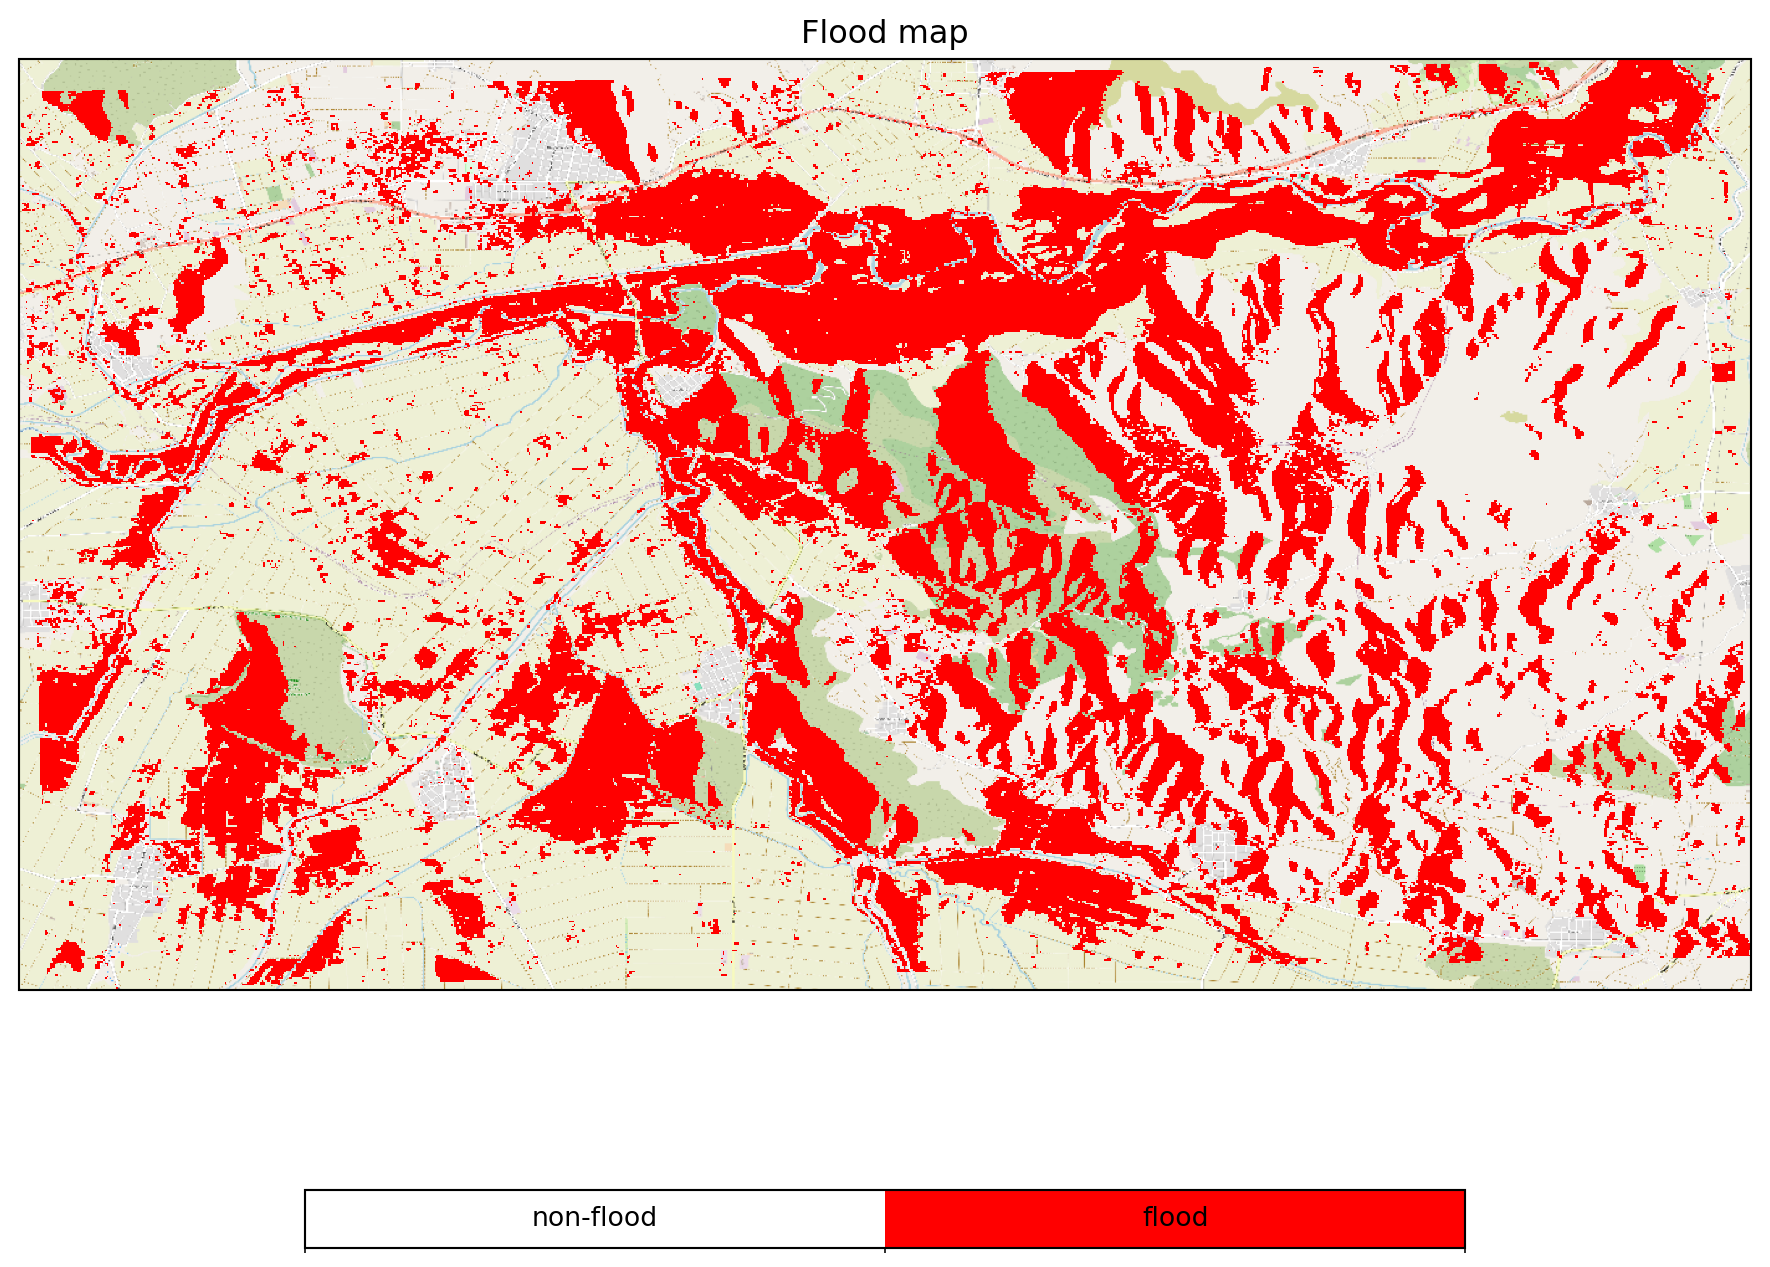

In [20]:
#| fig-cap: openEO floodmap - no pre-processing
view_flood_map(xr.open_dataset("data/thessaly_floodmap.nc").dec)

We can than also again extend this pipeline to include the postprocessing steps.

1) Masking of Exceeding Incidence Angles


In [21]:
mask_ia = (flood_dc.band("MPLIA") >= 27) * (flood_dc.band("MPLIA") <= 48)
flood_dc = flood_dc * mask_ia

In [22]:
#| eval: false
#| code-fold: true
flood_res = flood_dc.save_result(format = "NetCDF")
flood_job = flood_res.create_job(title = "flood_greece_flood_2018_as_NetCDF_py")
flood_job.start_job()
flood_job.download_result("data/thessaly_floodmap_plia.nc")

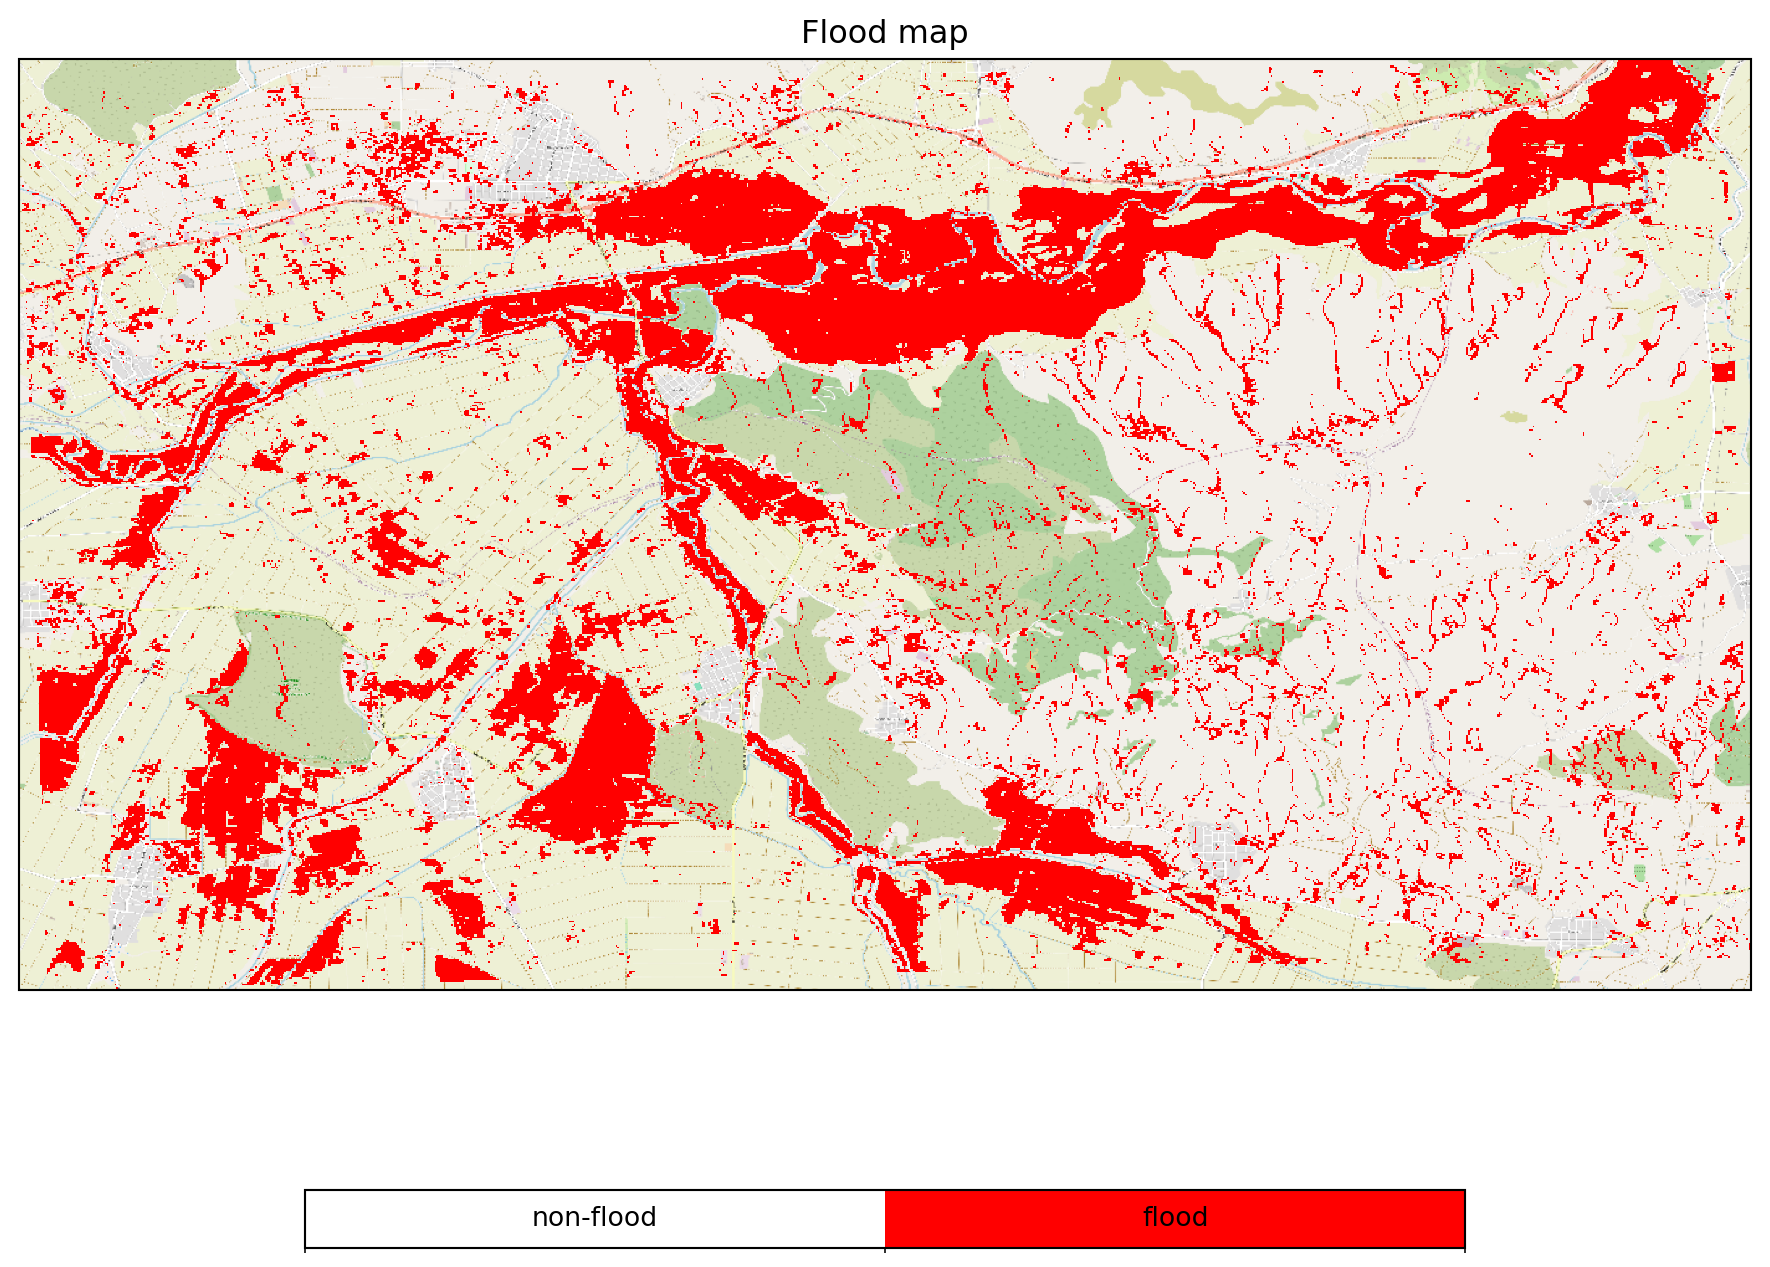

In [23]:
#| fig-cap: openEO floodmap - masking exceeding incidence angles
#| echo: false
view_flood_map(xr.open_dataset("data/thessaly_floodmap_plia.nc").dec)

2) Identification of Conflicting Distributions


In [24]:
water_bsc_threshold = flood_dc.band("wbsc") + 0.5 * 2.754041
mask_conflict = flood_dc.band("hbsc") > water_bsc_threshold
flood_dc = flood_dc * mask_conflict

In [25]:
#| eval: false
#| code-fold: true
flood_res = flood_dc.save_result(format = "NetCDF")
flood_job = flood_res.create_job(title = "flood_greece_flood_2018_as_NetCDF_py")
flood_job.start_job()
flood_job.download_result("data/thessaly_floodmap_plia_distr.nc")

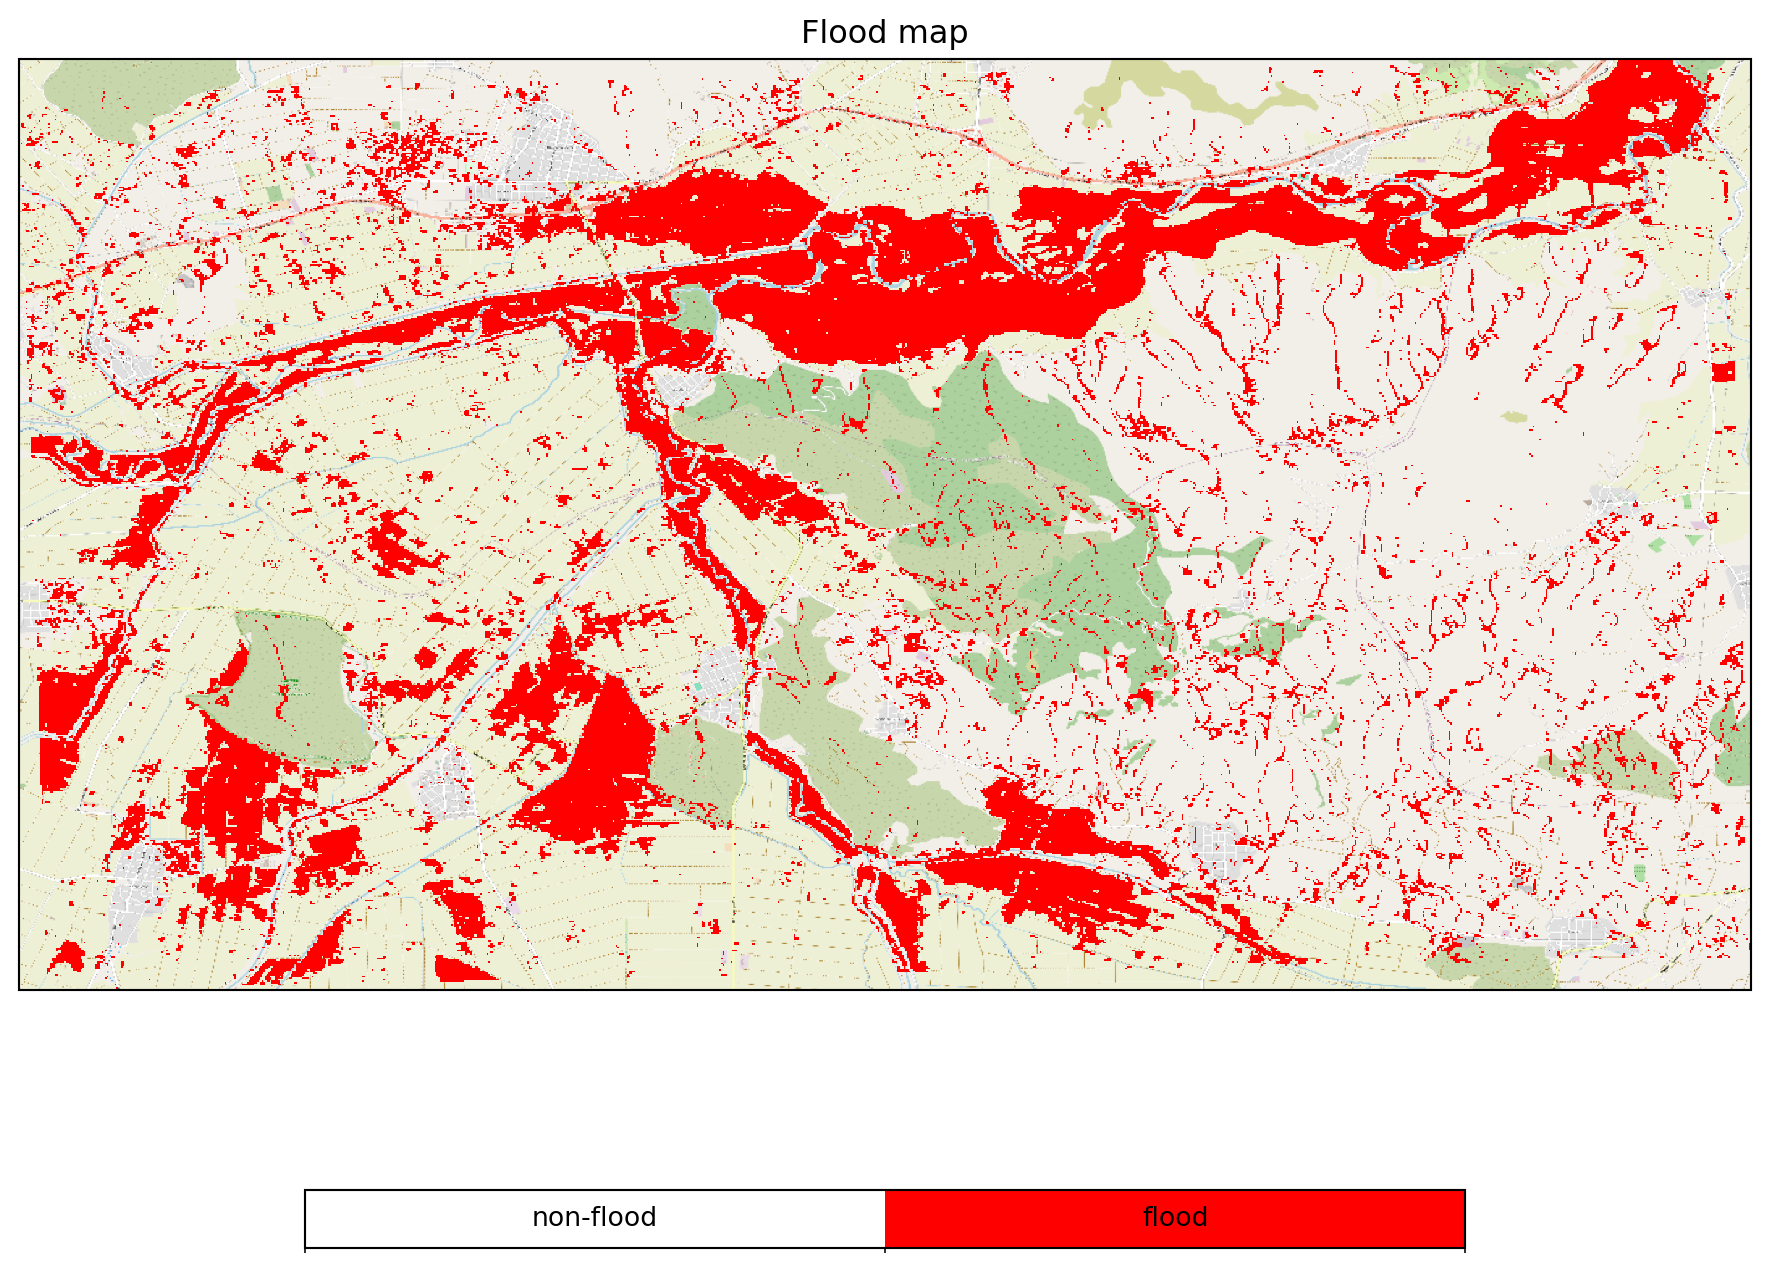

In [26]:
#| fig-cap: openEO floodmap - masking conflicting distributions + exceeding incidence angles
#| echo: false
view_flood_map(xr.open_dataset("data/thessaly_floodmap_plia_distr.nc").dec)

3) Removal of Measurement Outliers


In [27]:
land_bsc_lower = flood_dc.band("hbsc") - 3 * flood_dc.band("std")
land_bsc_upper = flood_dc.band("hbsc") + 3 * flood_dc.band("std")
water_bsc_upper = flood_dc.band("wbsc") + 3 * 2.754041

mask_land_outliers = (flood_dc.band("sig0") > land_bsc_lower) * (flood_dc.band("sig0") < land_bsc_upper)
mask_water_outliers = flood_dc.band("sig0") < water_bsc_upper
flood_dc = flood_dc * (mask_land_outliers | mask_water_outliers)

In [28]:
#| eval: false
#| code-fold: true
flood_res = flood_dc.save_result(format = "NetCDF")
flood_job = flood_res.create_job(title = "flood_greece_flood_2018_as_NetCDF_py")
flood_job.start_job()
flood_job.download_result("data/thessaly_floodmap_plia_distr_out.nc")

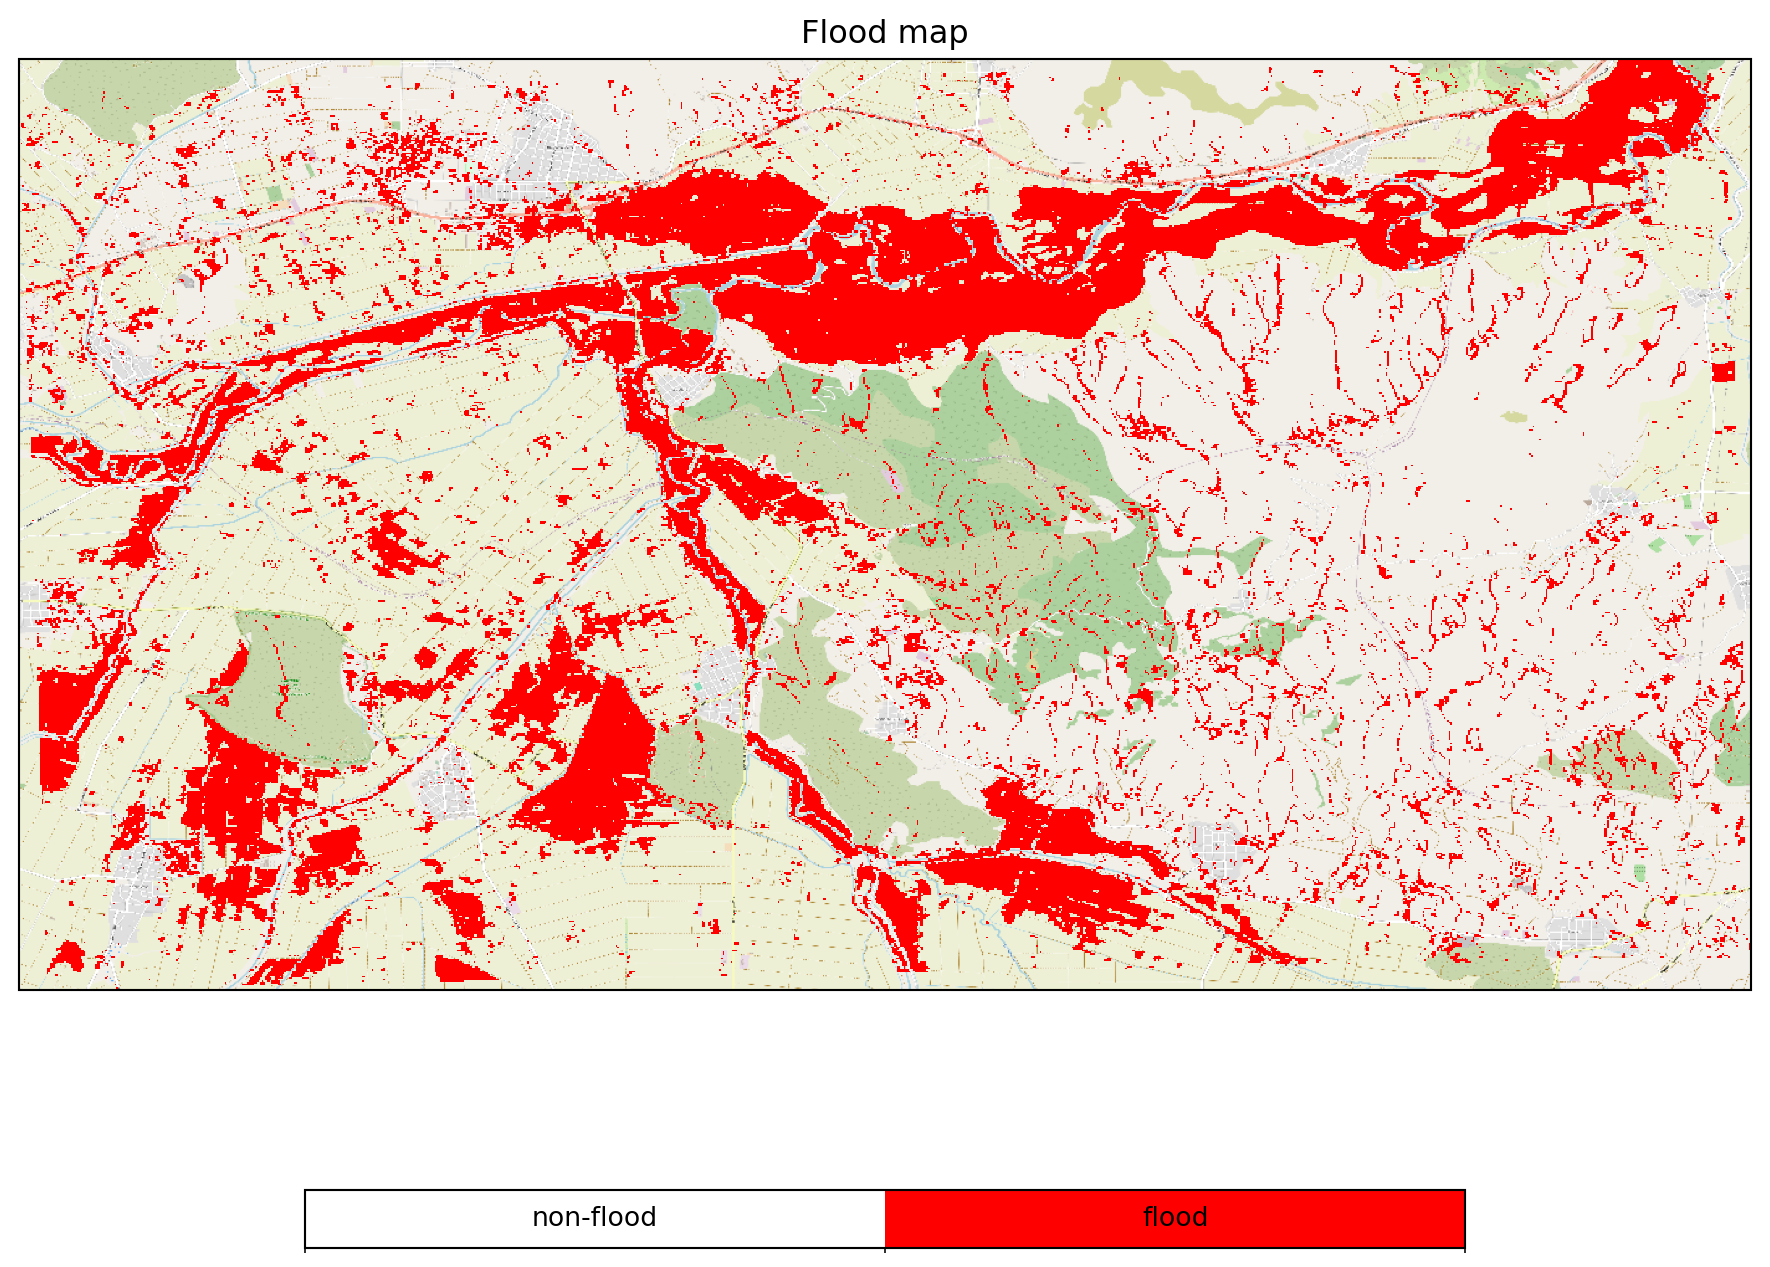

In [29]:
#| fig-cap: openEO floodmap - masking extreme outliers + conflicting distributions + exceeding incidence angles
#| echo: false
view_flood_map(xr.open_dataset("data/thessaly_floodmap_plia_distr_out.nc").dec)

4) Denial of High Uncertainty on Decision


In [30]:
mask_uncertainty = flood_dc.band("dec") > 0.8
flood_dc = flood_dc * mask_uncertainty

In [31]:
#| eval: false
#| code-fold: true
flood_res = flood_dc.save_result(format = "NetCDF")
flood_job = flood_res.create_job(title = "flood_greece_flood_2018_as_NetCDF_py")
flood_job.start_job()
flood_job.download_result("data/thessaly_floodmap_plia_distr_out_den.nc")

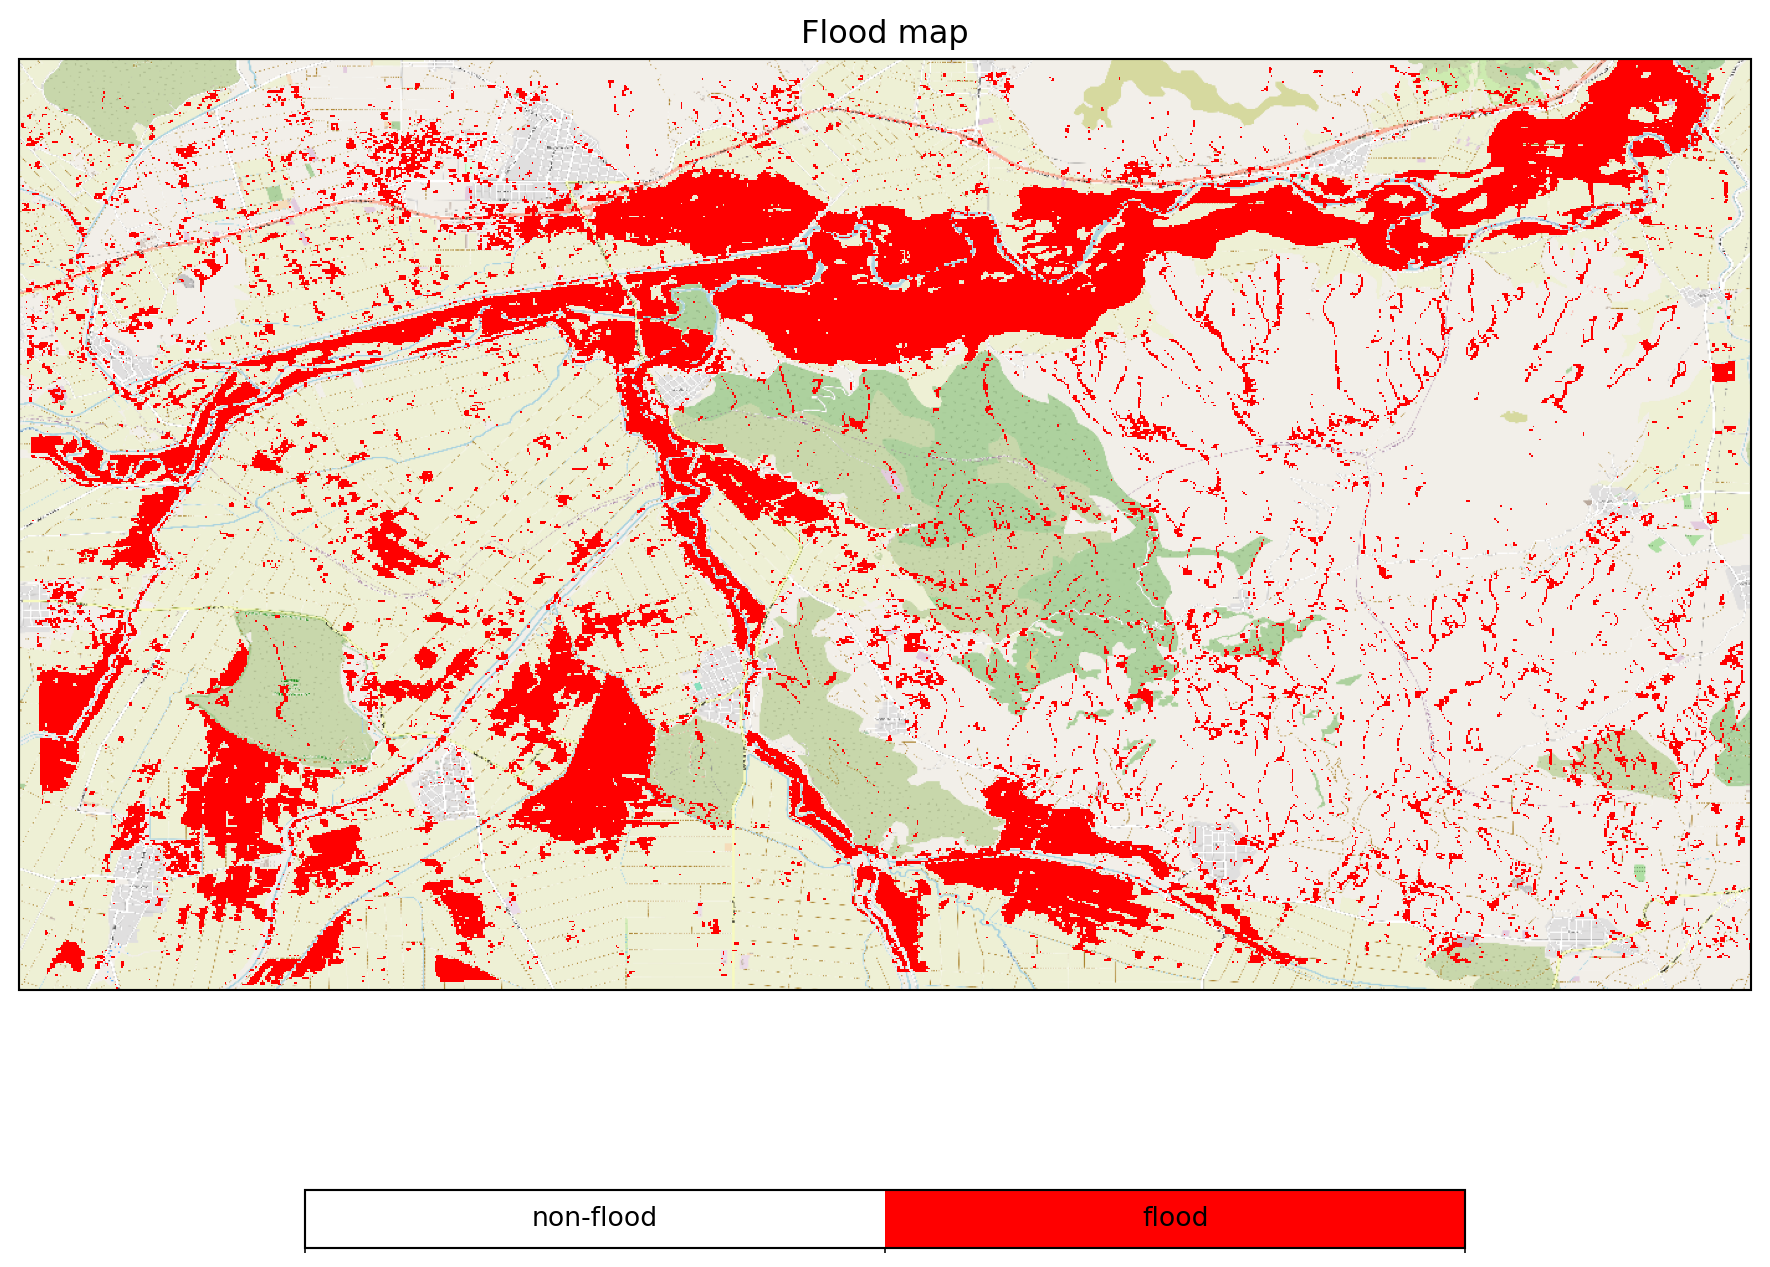

In [32]:
#| fig-cap: openEO floodmap - masking high uncertainty classifications + extreme outliers + conflicting distributions + exceeding incidence angles
#| echo: false
view_flood_map(xr.open_dataset("data/thessaly_floodmap_plia_distr_out_den.nc").dec)